In [5]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
path = Path('data')

In [8]:
paper_features_label = np.genfromtxt(path/'cora.content', dtype=str)
paper_features_label

array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
       ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
       ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
       ...,
       ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
       ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
       ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
      dtype='<U22')

In [9]:
labels = paper_features_label[:, -1]
lbl2idx = {k:v for v,k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
labels[:5]
print(len(labels))

2708


In [10]:
papers = paper_features_label[:,0].astype(np.int32)
papers

array([  31336, 1061127, 1106406, ..., 1128978,  117328,   24043],
      dtype=int32)

In [11]:
paper2idx = {k:v for v,k in enumerate(papers)}
edges = np.genfromtxt(path/'cora.cites', dtype=np.int32)
edges = np.asarray([paper2idx[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
edges

array([[ 163,  402],
       [ 163,  659],
       [ 163, 1696],
       ...,
       [1887, 2258],
       [1902, 1887],
       [ 837, 1686]], dtype=int32)

In [12]:
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)

adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [13]:
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [14]:
adj = normalize(adj + eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

In [15]:
adj = torch.FloatTensor(adj.todense())
labels = torch.LongTensor(labels)

In [19]:
np.random.seed(34)
n_train = 200
n_val = 300
n_test = len(labels) - n_train - n_val
idxs = np.random.permutation(len(labels))
idx_train = torch.LongTensor(idxs[:n_train])
idx_val   = torch.LongTensor(idxs[n_train:n_train+n_val])
idx_test  = torch.LongTensor(idxs[n_train+n_val:])

In [20]:
adj = adj.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [21]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, embedding_dim, num_layers, num_classes):
        super(LightGCN, self).__init__()

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.num_layers = num_layers
        self.classifier = nn.Linear(embedding_dim, num_classes)
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, adj):
        x = self.embedding.weight
        for _ in range(self.num_layers):
            x = torch.spmm(adj, x)  # Sparse matrix multiplication

        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

In [22]:
n_labels = labels.max().item() + 1
n_nodes = len(labels)
n_labels, n_nodes

(7, 2708)

In [23]:
torch.manual_seed(34)

model = LightGCN(num_nodes=n_nodes,
                 embedding_dim=64,
                 num_layers=20,
                 num_classes=n_labels)
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


model = model.to(device)

def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(adj)
    loss = F.nll_loss(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(adj)
    loss = F.nll_loss(output[idx], labels[idx])
    acc = accuracy(output[idx], labels[idx])

    return loss.item(), acc

In [24]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [25]:
epochs = 1000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]

    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]

        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  1%|          | 7/1000 [00:01<02:41,  6.14it/s]

Epochs: 0, Train Loss: 1.938, Train Acc: 0.140, Validation Loss: 1.917, Validation Acc: 0.197


 11%|█         | 111/1000 [00:02<00:11, 79.46it/s]

Epochs: 99, Train Loss: 1.586, Train Acc: 0.705, Validation Loss: 1.645, Validation Acc: 0.703


 21%|██        | 210/1000 [00:03<00:09, 82.56it/s]

Epochs: 199, Train Loss: 1.040, Train Acc: 0.835, Validation Loss: 1.191, Validation Acc: 0.777


 31%|███       | 309/1000 [00:05<00:08, 82.24it/s]

Epochs: 299, Train Loss: 0.783, Train Acc: 0.850, Validation Loss: 0.979, Validation Acc: 0.803


 42%|████▏     | 417/1000 [00:06<00:07, 81.79it/s]

Epochs: 399, Train Loss: 0.657, Train Acc: 0.885, Validation Loss: 0.881, Validation Acc: 0.810


 52%|█████▏    | 516/1000 [00:07<00:05, 82.79it/s]

Epochs: 499, Train Loss: 0.583, Train Acc: 0.895, Validation Loss: 0.827, Validation Acc: 0.823


 62%|██████▏   | 615/1000 [00:08<00:04, 82.57it/s]

Epochs: 599, Train Loss: 0.533, Train Acc: 0.900, Validation Loss: 0.793, Validation Acc: 0.827


 71%|███████▏  | 714/1000 [00:10<00:03, 82.00it/s]

Epochs: 699, Train Loss: 0.497, Train Acc: 0.910, Validation Loss: 0.771, Validation Acc: 0.823


 81%|████████▏ | 813/1000 [00:11<00:02, 82.52it/s]

Epochs: 799, Train Loss: 0.469, Train Acc: 0.920, Validation Loss: 0.755, Validation Acc: 0.817


 91%|█████████ | 912/1000 [00:12<00:01, 82.13it/s]

Epochs: 899, Train Loss: 0.446, Train Acc: 0.920, Validation Loss: 0.743, Validation Acc: 0.813


100%|██████████| 1000/1000 [00:13<00:00, 74.50it/s]

Epochs: 999, Train Loss: 0.428, Train Acc: 0.925, Validation Loss: 0.734, Validation Acc: 0.810


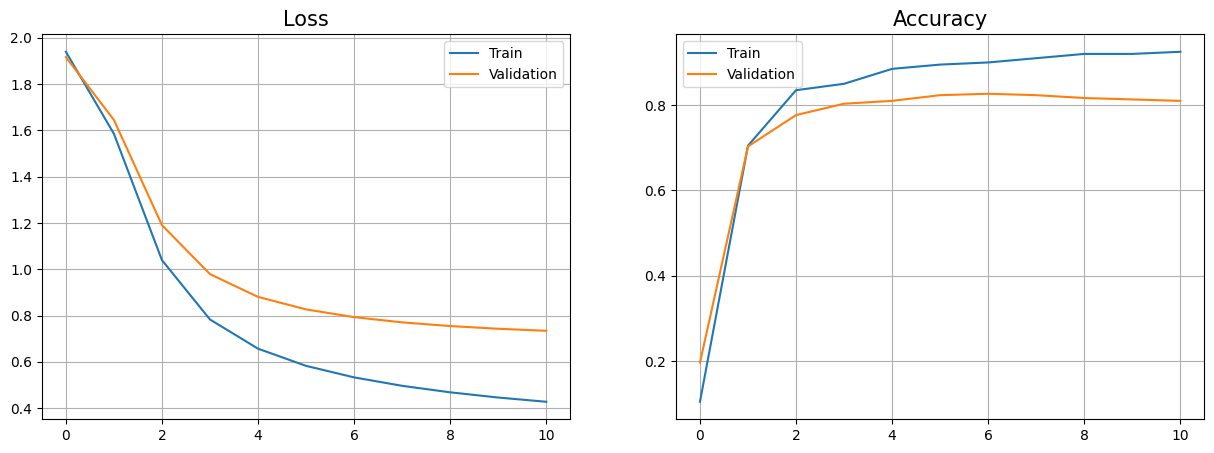

In [26]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
train_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_acc]
val_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_acc]
axes[1].plot(train_acc_cpu[::print_steps] + [train_acc_cpu[-1]], label='Train')
axes[1].plot(val_acc_cpu, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']):
    ax.legend(), ax.set_title(t, size=15)

In [27]:
output = model(adj)

In [28]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

,Real,Pred
0,Neural_Networks,Neural_Networks
1,Reinforcement_Learning,Reinforcement_Learning
2,Probabilistic_Methods,Probabilistic_Methods
3,Neural_Networks,Neural_Networks
4,Neural_Networks,Theory
5,Genetic_Algorithms,Genetic_Algorithms
6,Neural_Networks,Neural_Networks
7,Probabilistic_Methods,Probabilistic_Methods
8,Neural_Networks,Neural_Networks
9,Neural_Networks,Neural_Networks
